In [3]:
import numpy as np
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt
from scipy.signal import welch

import sys
sys.path.append('../../tool_code/python_tool_code/function/') # "~~/tool_code/plot/" (상대 경로)
sys.path.append('../../tool_code/python_tool_code/frequency_dataset_generation/')

from DataPlot import Data_Load_Plot, Result_Plot, Result_Plot_paper, Loss_Plot
from Scaling import time_scaling, time_inv_scaling
from FFT_func import FFT

In [4]:
import scipy.io
import h5py

from DataPlot_realdata import Data_Load_Plot, Result_Plot, Result_Plot_paper, Loss_Plot

def read_hdf5_mat_as_array(file_path):
    with h5py.File(file_path, 'r') as f:
        # HDF5의 모든 데이터를 numpy.array로 변환
        data = {key: np.array(f[key]) for key in f.keys()}
    return data

# 파일 경로
datapath1 = "C:/Users/stell/OneDrive/바탕 화면/PD_OpenLoop_ch12-13.mat"
datapath2 = "C:/Users/stell/OneDrive/바탕 화면/PD_rest(noStim)_ch12-13.mat"

# 데이터를 numpy.array 형식으로 로드
Contaminated_data = read_hdf5_mat_as_array(datapath1)
Clean_data = read_hdf5_mat_as_array(datapath2)
Contaminated_data = Contaminated_data['raw'].T
Clean_data = Clean_data['raw'].T

n_channels, n_samples = Contaminated_data.shape
print(Contaminated_data.shape)

# 채널 정보
stim_ch = 11
target_ch = 12

fs = 24414  # 샘플링 주파수
frequencies = np.linspace(-fs/2, fs/2, n_samples)  # 주파수 범위 설정
time = np.arange(n_samples) / fs # 시간 범위 설정

(16, 7324200)


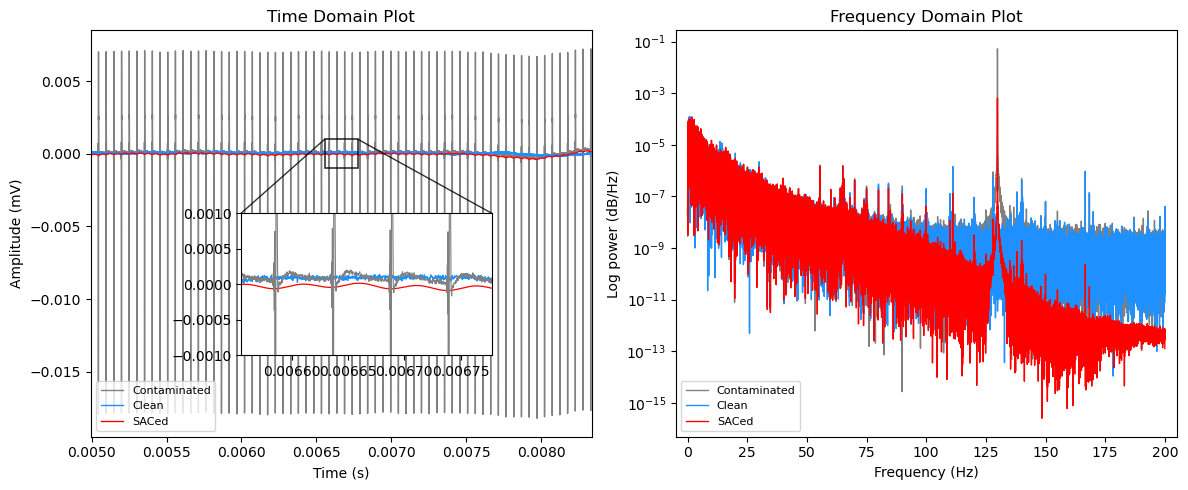

< MSE >
Time Domain MSE: 6.760672539590275e-07 ± 2.555668087617237e-06
Frequency Domain MSE: 1.8505388427211856e-07 ± 7.164023095608054e-07
Time + Frequency MSE: 1305.957288365728 ± 4818.667454373825


In [5]:
# Low Pass Filter
import numpy as np
from scipy.signal import butter, filtfilt

def lowpass_filter(data, cutoff, fs, order=4):
    nyquist = 0.5 * fs
    normal_cutoff = cutoff / nyquist
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    filtered_data = filtfilt(b, a, data)
    return filtered_data

LPFed = lowpass_filter(Contaminated_data, 100, fs)

save_path = '../../result/conventional_filter/'
save_title = 'LPF'

Result_Plot(Contaminated_data, LPFed, Clean_data) # inverse scaled data를 input으로 넣음

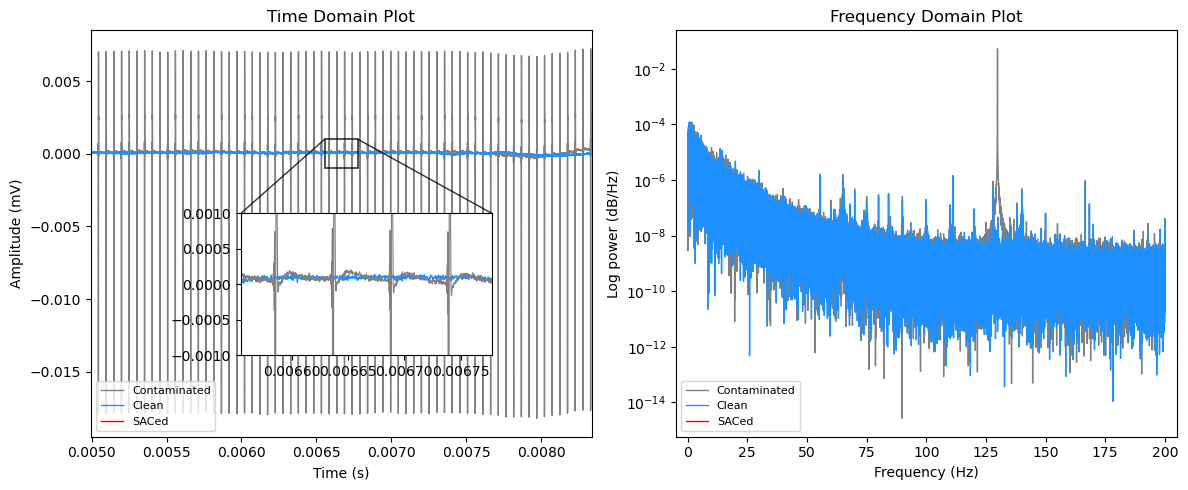

ValueError: Input contains NaN.

In [6]:
# 대역통과 필터 함수 정의
def bandpass_filter(data, lowcut, highcut, fs, order=4):
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(order, [low, high], btype='band')
    filtered_data = filtfilt(b, a, data)
    return filtered_data

# 필터 적용
BPFed = bandpass_filter(Contaminated_data, 12, 35, fs)

save_path = '../../result/conventional_filter/'
save_title = 'BPF'

Result_Plot(Contaminated_data, BPFed, Clean_data) # inverse scaled data를 input으로 넣음

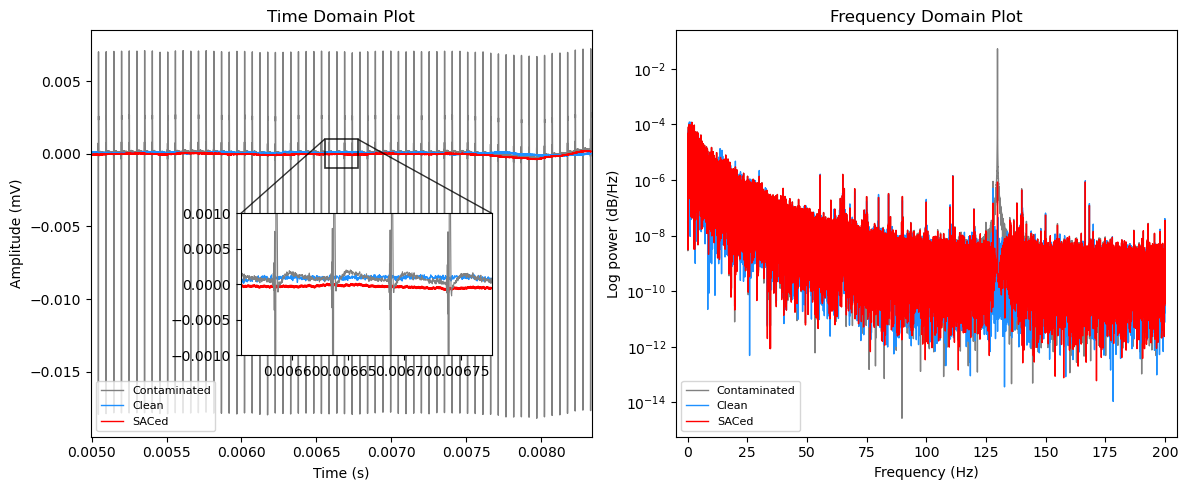

< MSE >
Time Domain MSE: 6.777743679208598e-07 ± 2.565324263931623e-06
Frequency Domain MSE: 1.852046269957796e-07 ± 7.163856083704019e-07
Time + Frequency MSE: 1314.1917819290868 ± 4849.9480802528915


In [9]:
import numpy as np
from scipy.signal import iirnotch, filtfilt

# 노치 필터 설계 및 적용 함수
def notch_filter(data, notch_freqs, fs, quality_factor):
    Notched = data
    for notch_freq in notch_freqs:
        b, a = iirnotch(notch_freq, quality_factor, fs)
        Notched = filtfilt(b, a, Notched)
    return Notched

fundamental_freq = 130
harmonics = [fundamental_freq * i for i in range(1, int(fs/(2*fundamental_freq)) + 1)]  # 130Hz의 배수 계산

quality_factor = 30

Notched = notch_filter(Contaminated_data, harmonics, fs, quality_factor)

# 결과 Plot
save_path = '../../result/paper/'
save_title = 'Notch'

Result_Plot(Contaminated_data, Notched, Clean_data) # inverse scaled data를 input으로 넣음
# Result_Plot_paper(Contaminated, Notched, Clean, save_path, save_title) # inverse scaled data를 input으로 넣음